# Singal To Noise All Models
 - Calculates the singal to nosie for all models in longrunmip for GMST
 - Fraction of models stable for windows for GMST
 
 PHD-9:
 * read_and_merge_netcdfs moved from longrunmip_loader to open_ds


In [2]:
import warnings
from classes import ExperimentTypes
import utils
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
import xarray_class_accessors as xca
import sn_plotting as sn_plot
import xarray as xr
import numpy as np
from importlib import reload
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

import os
import sys

import constants
sys.path.append(constants.MODULE_DIR)

warnings.filterwarnings('ignore')

logger = utils.get_notebook_logger()

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory('dask-worker-space')
dask.distributed.Client(local_directory=tempdir.name, memory_limit='32gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 119.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36493,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 119.21 GiB
Comm: tcp://127.0.0.1:32917,Total threads: 4
Dashboard: http://127.0.0.1:37337/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:42295,


In [3]:
constants.EXPERIMENTS_TO_RUN

[{'variable': 'tas', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'tas', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'tos', 'mask': 'sea', 'hemisphere': 'global'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'global'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'northern_hemisphere'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'southern_hemisphere'}]

In [4]:
notebook_number='03_00'
experiment_params = constants.EXPERIMENTS_TO_RUN[0] # 0, 1, 2 3, 4, 5, 6, 7
experiment_params

{'variable': 'tas', 'mask': None, 'hemisphere': 'global'}

In [5]:
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, experiment_params["variable"], 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

In [6]:
units = constants.VARIABLE_INFO[experiment_params["variable"]]["units"]
longname = constants.VARIABLE_INFO[experiment_params["variable"]]['longname']
print(f'{longname=}', f'{units=}', sep=' , ')

longname='Near-Surface\nAir Temperature' , units='$^{\\circ}C$'


# Loading Data

In [13]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [14]:
files_to_open_experiment = open_ds.get_file_names_from_from_directory(
    ROOT_DIR, ExperimentTypes.ABRUPT4X, models_to_get)

files_to_open_control = open_ds.get_file_names_from_from_directory(
    ROOT_DIR, ExperimentTypes.CONTROL, models_to_get)

utils.pprint_list(files_to_open_experiment, num_start_items=5)

lenght = 7
 0. tas_mon_CCSM3_abrupt4x_2120_g025.nc
 1. tas_mon_CESM104_abrupt4x_5900_g025.nc
 2. tas_mon_CNRMCM61_abrupt4x_1850_g025.nc
 3. tas_mon_HadCM3L_abrupt4x_1000_g025.nc
 4. tas_mon_IPSLCM5A_abrupt4x_1000_g025.nc


In [15]:
control_ds = open_ds.read_and_merge_netcdfs(files_to_open_control, ROOT_DIR, 
                                            mask=experiment_params['mask'])
abrupt4x_ds = open_ds.read_and_merge_netcdfs(files_to_open_experiment, ROOT_DIR,
                                             mask=experiment_params['mask'])
abrupt4x_ds

- Removing first 10 steps


<xarray.Dataset>
Dimensions:   (time: 1200, lon: 144, lat: 72)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    height    float64 ...
Data variables:
    ccsm3     (time, lat, lon) float32 -36.44 -36.81 -36.81 ... -2.414 -2.413
    cesm104   (time, lat, lon) float32 -42.74 -42.83 -42.9 ... -4.047 -4.015
    cnrmcm61  (time, lat, lon) float32 -47.32 -47.32 -47.33 ... 4.162 4.18 4.18
    hadcm3l   (time, lat, lon) float64 -43.95 -44.02 -43.9 ... nan nan nan
    ipslcm5a  (time, lat, lon) float32 -42.89 -43.01 -43.13 ... nan nan nan
    mpiesm11  (time, lat, lon) float32 -47.93 -47.92 -47.89 ... 1.017 1.015
    mpiesm12  (time, lat, lon) float32 -48.58 -48.6 -48.65 ... nan nan nan
Attributes:
    length:   2120

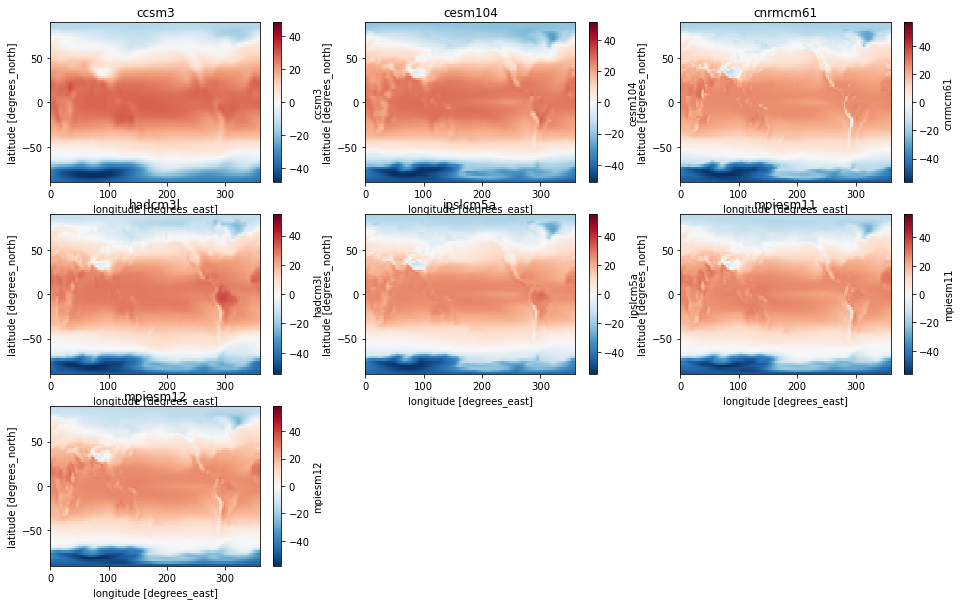

In [16]:
models = list(abrupt4x_ds.data_vars)
num_cols = 3
num_rows = int(np.ceil(len(models)/num_cols))

fig = plt.figure(figsize=(16,10))

for i,model in enumerate(models):
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    
    abrupt4x_ds[model].isel(time=0).plot(ax=ax)
    ax.set_title(model)
    
    ax.set_title(model)

In [12]:
abrupt4x_mean,control_ds_mean = sn.calculate_global_value(abrupt4x_ds, control_ds, 
                                                          experiment_params["variable"],
                                                constants.HEMISPHERE_LAT[experiment_params['hemisphere']])

ccsm3, cesm104, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 

In [13]:
constants.MULTI_WINDOW_RUN_PARAMS

{'start_window': 10, 'end_window': 152, 'step_window': 1}

In [14]:
max_effective_length =  constants.LONGRUNMIP_LENGTH#sn.get_upper_lim(abrupt4x_mean, constants.MULTI_WINDOW_RUN_PARAMS['end_window'])
max_effective_length

800

In [15]:
%%time
stable_sn_ds, unstable_sn_ds = abrupt4x_mean.sn_ds.sn_multiwindow(
    control_ds_mean, parallel=True, **constants.MULTI_WINDOW_RUN_PARAMS)

- 
====ccsm3


Experiment
--------

range(10, 152)
10, 13, 19, 16, 22, 25, 28, 31, 34, 37, 40, 43, 46, 52, 55, 49, 20, 23, 14, 26, 11, 17, 29, 56, 44, 35, 18, 24, 41, 50, 47, 32, 38, 15, 12, 27, 57, 21, 53, 30, 36, 51, 45, 42, 33, 39, 54, 48, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 65, 94, 97, 62, 71, 59, 80, 100, 68, 74, 77, 83, 103, 86, 92, 66, 95, 72, 81, 63, 60, 98, 75, 101, 69, 89, 78, 84, 106, 87, 104, 109, 99, 112, 93, 115, 121, 118, 90, 124, 102, 96, 127, 130, 105, 133, 107, 110, 122, 136, 116, 139, 142, 125, 145, 131, 148, 108, 128, 113, 151, 119, 111, 134, 143, 140, 149, 137, 146, 126, 123, 117, 135, 129, 144, 114, 132, 150, 141, 138, 120, 147, 
Control
------

range(10, 152)
10, 13, 16, 19, 22, 31, 37, 25, 28, 34, 40, 46, 49, 52, 43, 55, 17, 23, 26, 29, 11, 35, 14, 53, 20, 41, 50, 32, 38, 44, 27, 18, 36, 47, 30, 56, 54, 51, 39, 24, 42, 15, 58, 12, 61, 21, 45, 64, 33, 57, 67, 70, 73, 76, 48, 79, 82, 71, 59, 65, 62, 68, 80, 77, 83, 85, 60, 88, 91, 74, 63, 94, 97, 72, 6

In [16]:
number_models_present = sn.count_over_data_vars(abrupt4x_mean, list(unstable_sn_ds.data_vars), dim='model')

unstable_number_da = sn.number_finite(unstable_sn_ds)
stable_number_da = sn.number_finite(stable_sn_ds)

unstable_number_da

<xarray.DataArray (window: 142, time: 1192)>
array([[0, 7, 7, ..., 0, 0, 1],
       [7, 7, 7, ..., 1, 0, 0],
       [0, 7, 7, ..., 0, 0, 0],
       ...,
       [7, 7, 7, ..., 0, 0, 0],
       [0, 7, 7, ..., 0, 0, 0],
       [7, 7, 7, ..., 0, 0, 0]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1192-12-31 00:00:00
    height   float64 2.0
  * window   (window) int64 10 11 12 13 14 15 16 ... 145 146 147 148 149 150 151

In [17]:
%%time
stable_point_ds = sn.get_dataset_stable_year_multi_window(unstable_sn_ds).rename({'variable': 'model'})
stable_point_ds

Replacing points greater than 1192 with 1193
Replacing points greater than 1192 with 1193
Replacing points greater than 1192 with 1193
Replacing points greater than 1192 with 1193
Replacing points greater than 1192 with 1193
Replacing points greater than 1192 with 1193
Replacing points greater than 1192 with 1193
CPU times: user 4.19 s, sys: 216 ms, total: 4.4 s
Wall time: 4.75 s


<xarray.Dataset>
Dimensions:  (window: 142, model: 7)
Coordinates:
    height   float64 2.0
  * window   (window) int64 10 11 12 13 14 15 16 ... 145 146 147 148 149 150 151
  * model    (model) <U8 'ccsm3' 'cesm104' 'cnrmcm61' ... 'mpiesm11' 'mpiesm12'
Data variables:
    time     (model, window) int64 21 20 20 30 31 29 ... 678 677 678 677 677 676

In [18]:
# stable_point_ds = xr.where(stable_point_ds.time > max_effective_length, stable_point_ds, stable_point_ds.time)

# Plots

### Mean Temp Plots

In [19]:
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))
hemisphere_title

'Global'

In [20]:
mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''
mask_title

''

In [21]:
run_tag = f'{notebook_number}_{experiment_params["variable"]}' +\
        f'_{experiment_params["hemisphere"]}_mask_{experiment_params["mask"]}'
run_tag

'03_00_tas_global_mask_None'

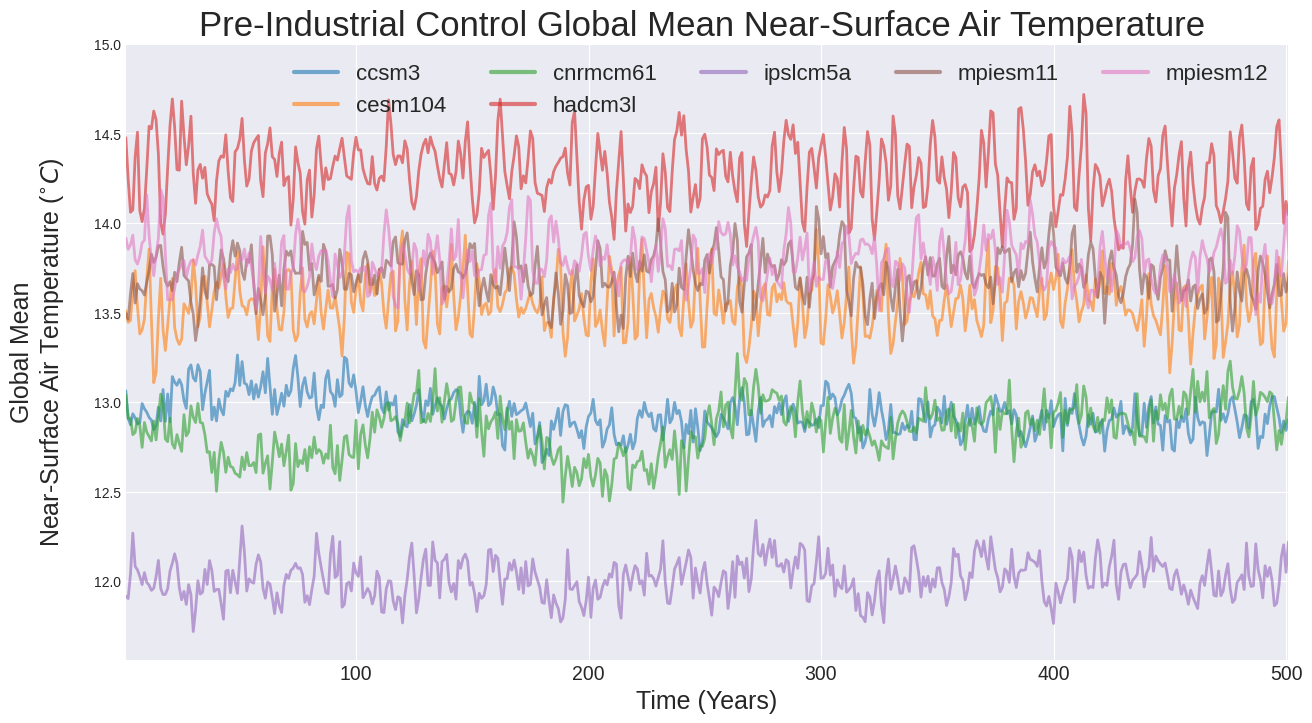

In [33]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = control_ds_mean['time'].values
years = [t.year for t in time]
for var in list(control_ds_mean.data_vars):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, control_ds_mean[var].values, label=var, **plot_kwargs) #  - 273.15
    
ax.set_ylabel(f'{hemisphere_title} Mean\n{longname} ({units})', size=18, labelpad=20)
ax.set_xlabel('Time (Years)', size=18)
ax.set_xlim(years[0], years[500])
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title(f'Pre-Industrial Control {hemisphere_title} Mean {longname} {mask_title}', fontsize=25);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}__mean_control.png'))

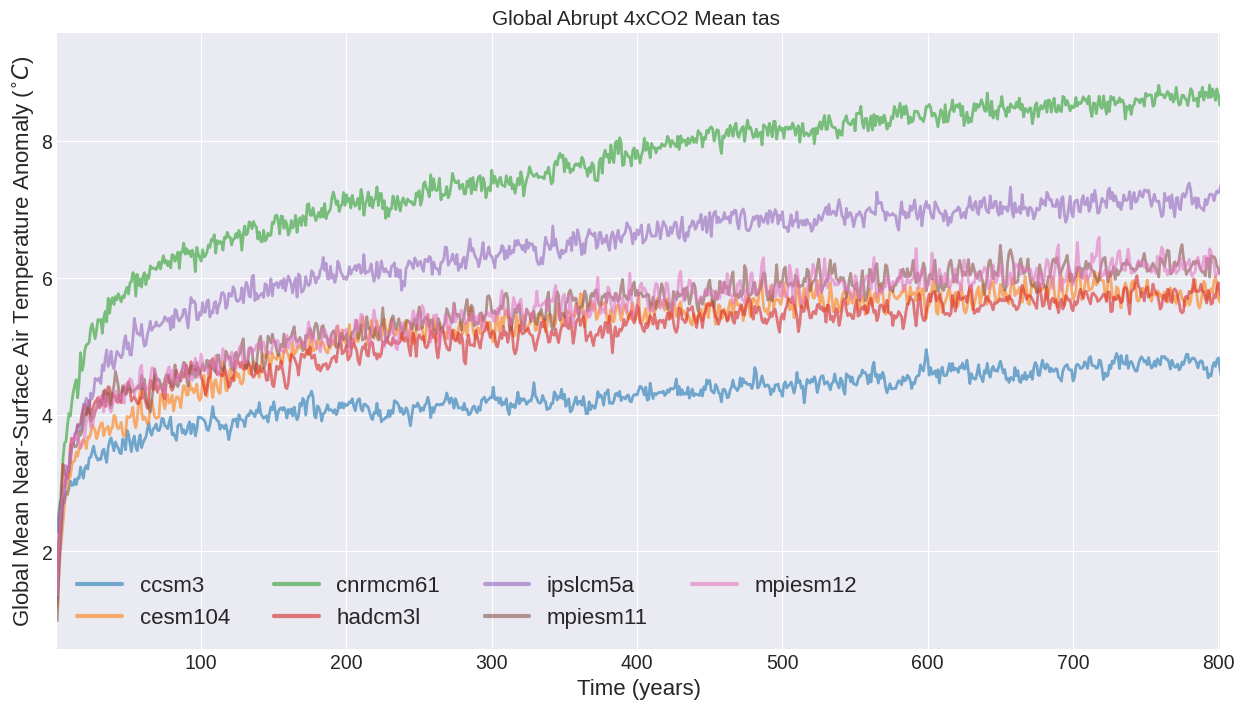

In [61]:
plt.style.use('seaborn-darkgrid')

data = abrupt4x_mean.where(abrupt4x_mean.time.dt.year < 13500, drop = True)

fig, ax = plt.subplots(figsize=(15,8))

for var in list(data.data_vars):
    
    # Removing nans from data
    da = data[var].dropna(dim='time')
    time = da.time.values
    years = [t.year for t in time]

    values = da.values
    
    line_kwargs = dict(alpha = 0.6,linewidth = 2)
    
    ax.plot(years, values, label=var, **line_kwargs)
    c = plt.gca().lines[-1].get_color()
#     ax.annotate(var, xy = (time[-1], values[-1]), color=c, zorder=1000, size=12)

ax.set_ylabel(f'{hemisphere_title} Mean {longname} Anomaly ({units})', size=16)
ax.set_xlabel('Time (years)', size=16);
ax.set_title(f'{hemisphere_title} Abrupt 4xCO2 Mean {experiment_params["variable"]} {mask_title}', fontsize=15);

# ax.set_ylim([0,15]);|
ax.set_xlim(years[0], years[max_effective_length])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol=4, fontsize = 16);
[line.set_linewidth(3) for line in leg.get_lines()];
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_mean_abrupt4x.png'))

### Signal to Noise

In [24]:
models = [model for model in list(constants.MODEL_PARAMS) if model in stable_point_ds.model.values]
models

['ccsm3', 'mpiesm12', 'cesm104', 'hadcm3l', 'mpiesm11', 'ipslcm5a', 'cnrmcm61']

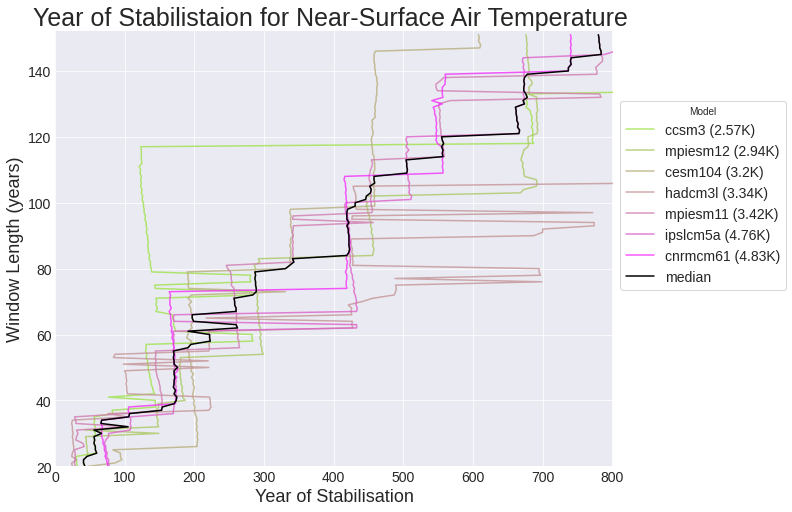

In [25]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111)

for model in models:
    color = constants.MODEL_PARAMS[model]['color']
    ECS = constants.MODEL_PARAMS[model]['ECS']
    label = f'{model} ({ECS}K)' 
    da = stable_point_ds.sel(model=model).time.plot(ax=ax,y='window', label=label, color=color, linewidth=1.5,
                                                   alpha=0.8)
    
stable_point_ds.median(dim='model').time.plot(ax=ax,y='window', label='median', color='k', linewidth=1.5) 

ax.set_xlim(0, max_effective_length + 1)
ax.set_ylim(20, constants.MULTI_WINDOW_RUN_PARAMS['end_window'])
leg = ax.legend(ncol=1, bbox_to_anchor=[1, 0.857], frameon=True, facecolor='white', fontsize=14)
leg.set_title('Model')
leg.get_title().set_fontsize('10')
title = f'Year of Stabilistaion for {longname} {mask_title}' #{hemisphere_title} 
ax.set_title(title, fontsize=25)
ax.set_xlabel('Year of Stabilisation', fontsize=18)
ax.set_ylabel('Window Length (years)', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)


save_name = os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_all_models_stable_year.png')

fig.savefig(save_name, bbox_inches='tight', dpi=200)

In [26]:
models

['ccsm3', 'mpiesm12', 'cesm104', 'hadcm3l', 'mpiesm11', 'ipslcm5a', 'cnrmcm61']

In [42]:
reload(sn_plot)


<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/modules/sn_plotting.py'>

ccsm3
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_tas_global_mask_None_ccsm3_signal_to_noise_multiwindow.png
mpiesm12
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_tas_global_mask_None_mpiesm12_signal_to_noise_multiwindow.png
cesm104
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_tas_global_mask_None_cesm104_signal_to_noise_multiwindow.png
hadcm3l
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_tas_global_mask_None_hadcm3l_signal_to_noise_multiwindow.png
mpiesm11
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_tas_global_mask_None_mpiesm11_signal_to_noise_multiwindow.png
ipslcm5a
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_tas_

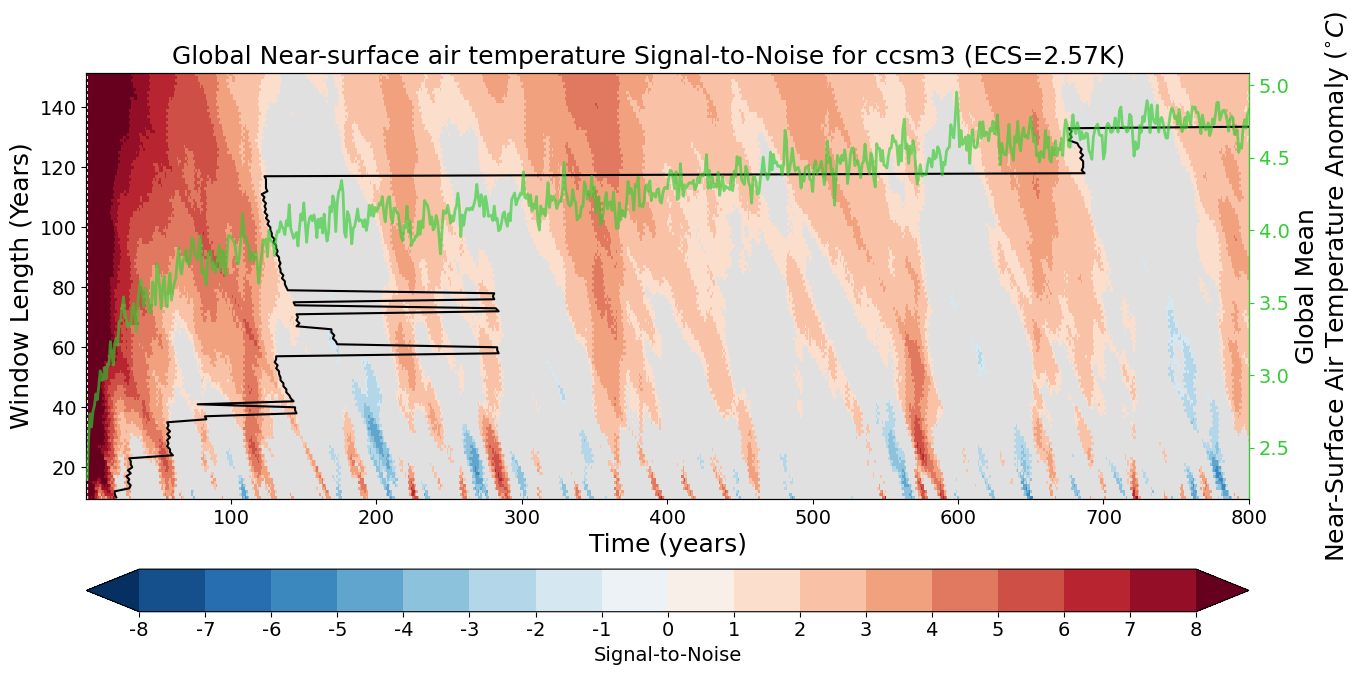

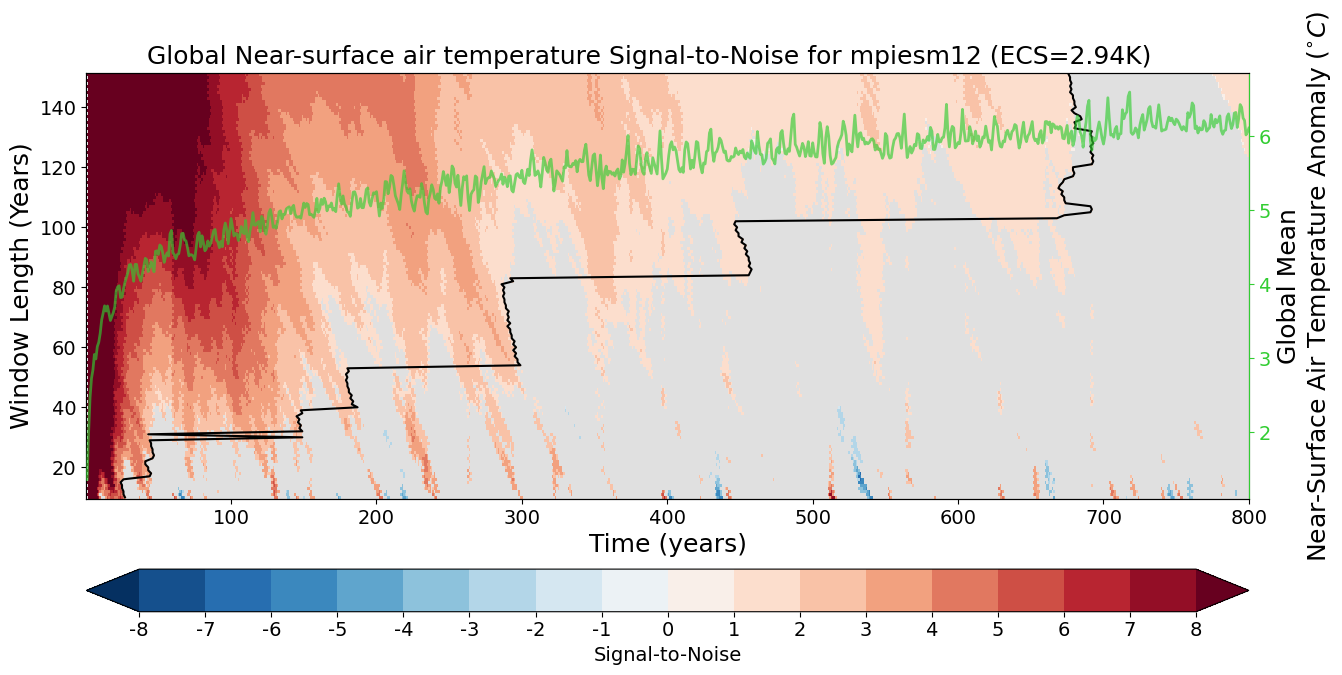

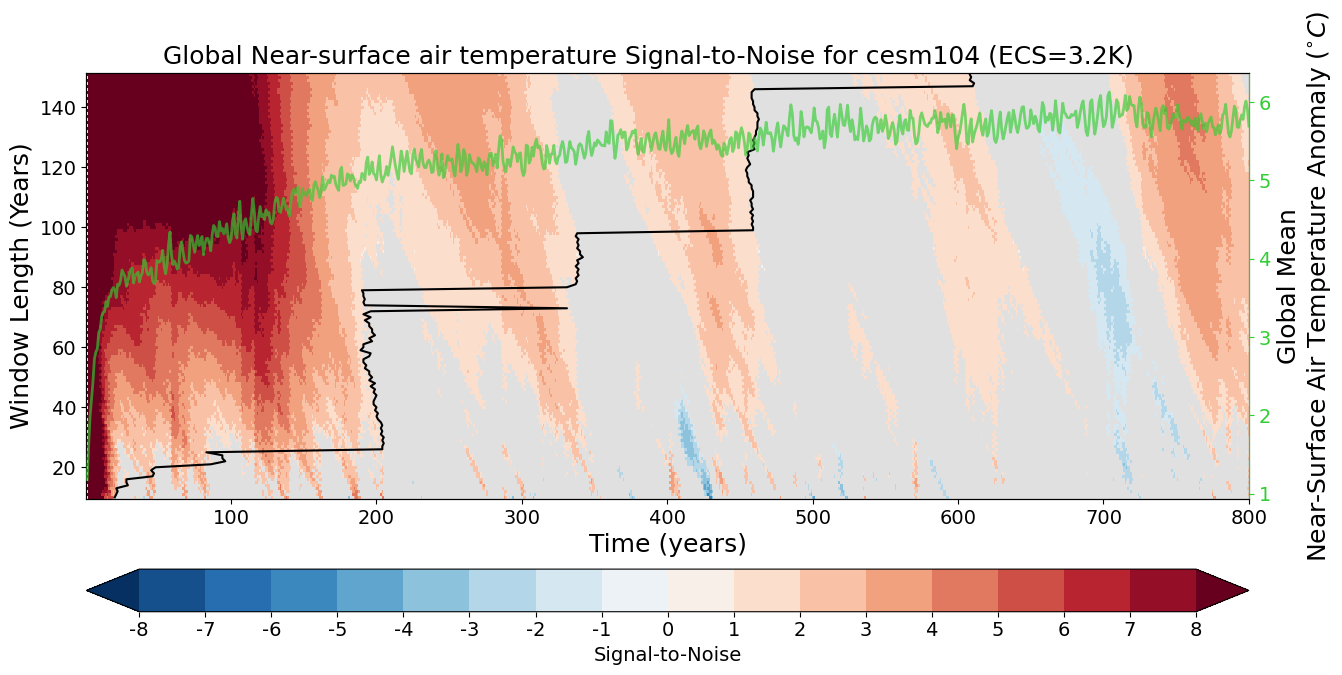

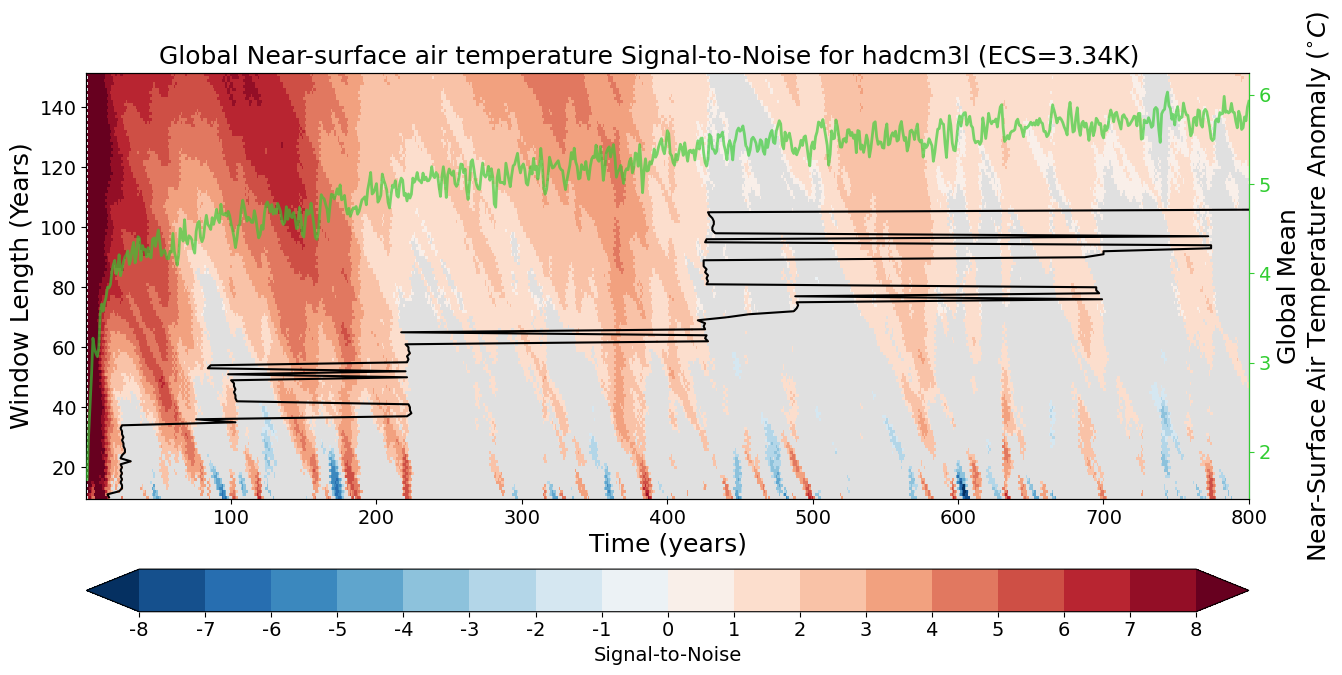

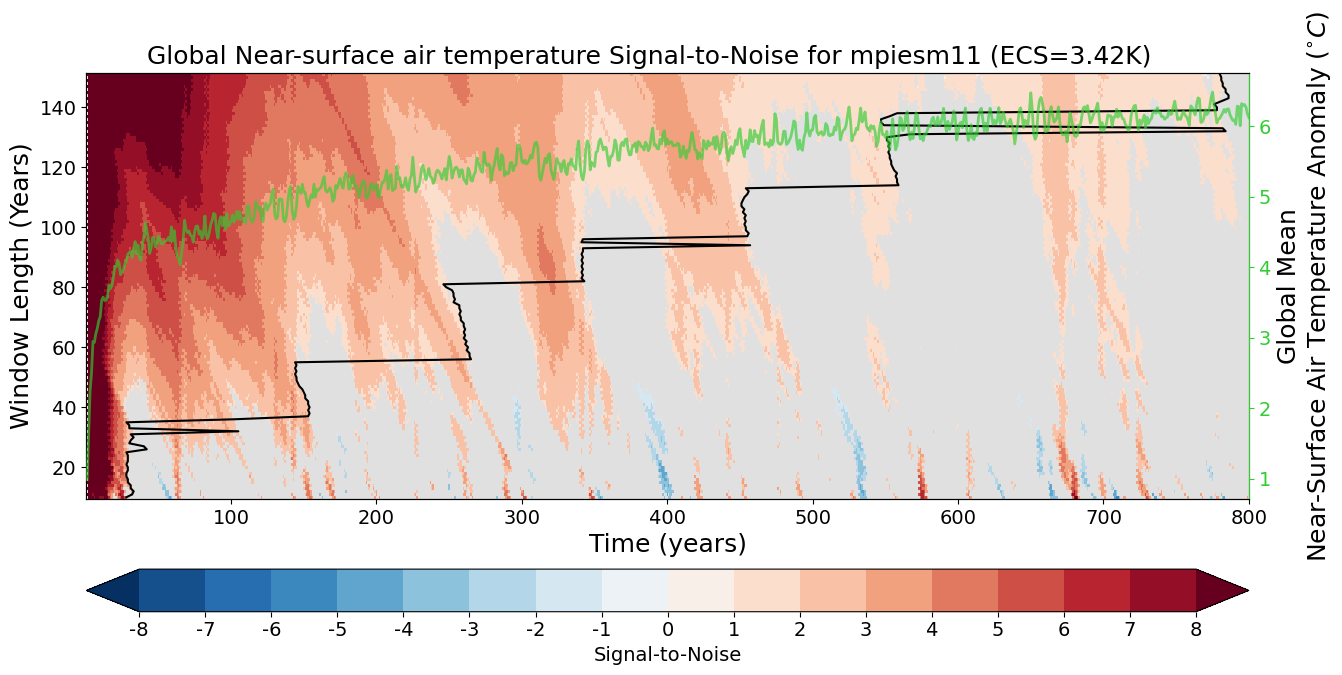

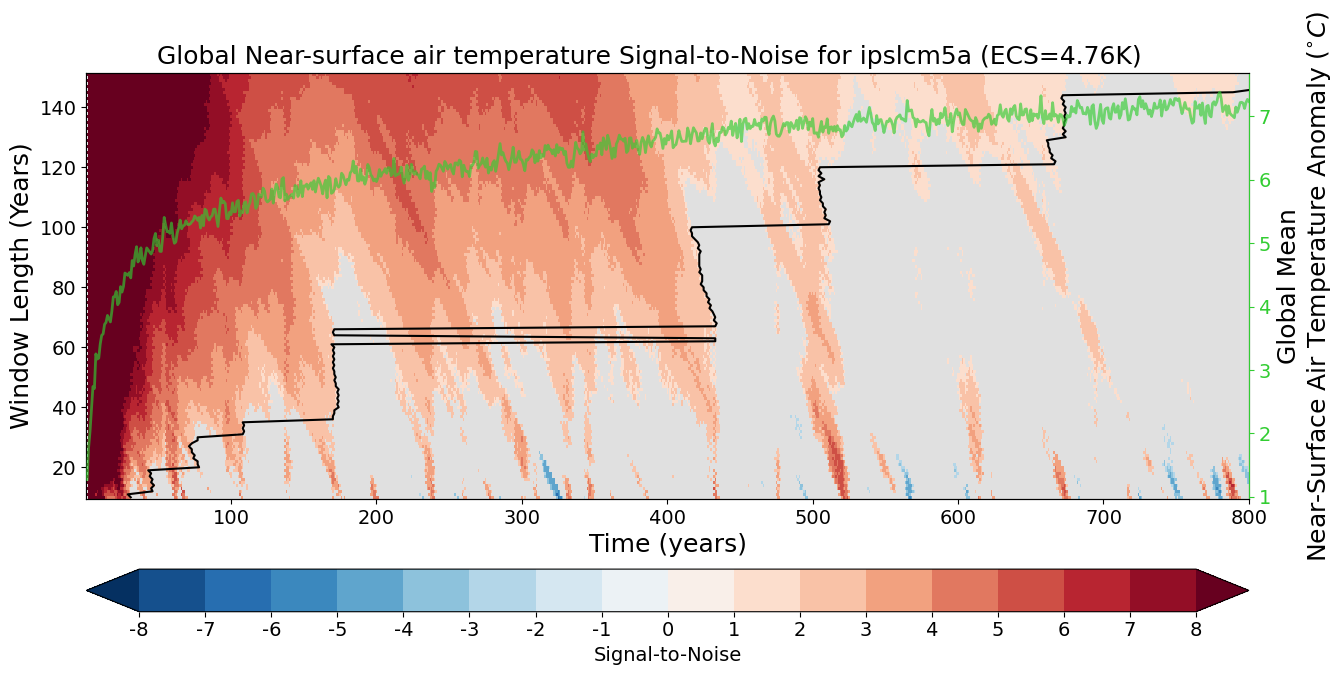

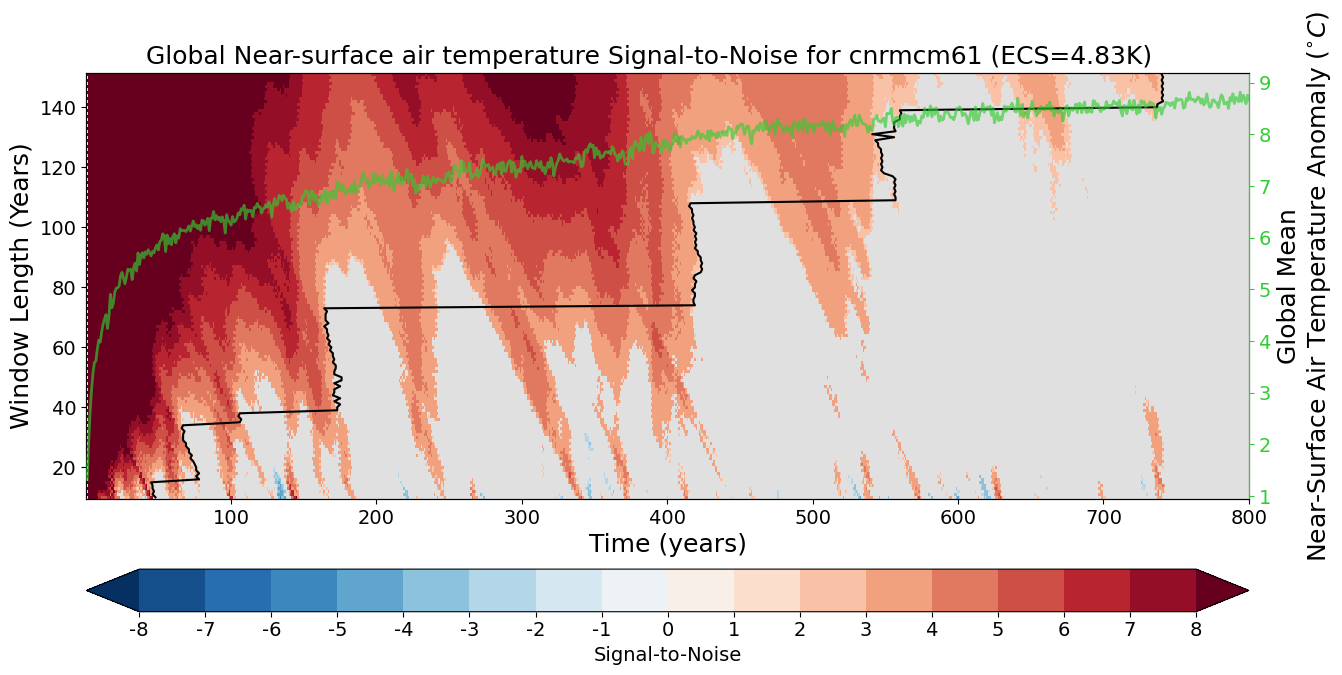

In [59]:
reload(sn_plot)
mpl.rcParams.update(mpl.rcParamsDefault)

for model in list(models):
    print(model)
    ECS = constants.MODEL_PARAMS[model.lower()]['ECS']
    title = f'{hemisphere_title} {longname.capitalize()} Signal-to-Noise for {model} {mask_title}(ECS={ECS}K)'
    (fig, ax1, ax2, ax3, cbar) = sn_plot.sn_multi_window_in_time(unstable_sn_ds[model], 
                            stable_sn_ds[model], abrupt4x_mean[model].dropna(dim='time'),
                            stable_point_ds = stable_point_ds.sel(model=model),
                            title=title, step=1, xupperlim=max_effective_length, cbar_label='Signal-to-Noise',
                            ax2_ylabel = f'{hemisphere_title} Mean\n{longname} Anomaly ({units})',
                                                                logginglevel='ERROR');

#     stable_point_ds.sel(model=model).time.plot(y='window',  ax=ax1, color='k')
#     ax1.set_title('')
#     ax1.set_ylabel('Window Length (Years)', fontsize=15)
#     ax1.set_xlabel('Time (Years)', fontsize=16)
#     ax2.set_xlabel('Time (Years)', fontsize=16)
    
    save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{run_tag}_{model}_signal_to_noise_multiwindow.png')
    
    print(f'Saving {save_name}')
    fig.savefig(save_name, dpi=400, bbox_inches='tight')

In [56]:
experiment_params["variable"] in ['sic', 'surf']

False

In [57]:
cmap = "Blues" if experiment_params["variable"] in ['sic', 'surf'] else 'Reds'
cmap

'Reds'

/home/563/ab2313/gdata/images/PhD/top_level/03_00_tas_global_mask_None_all_models_signal_to_noise_multiwindow.png


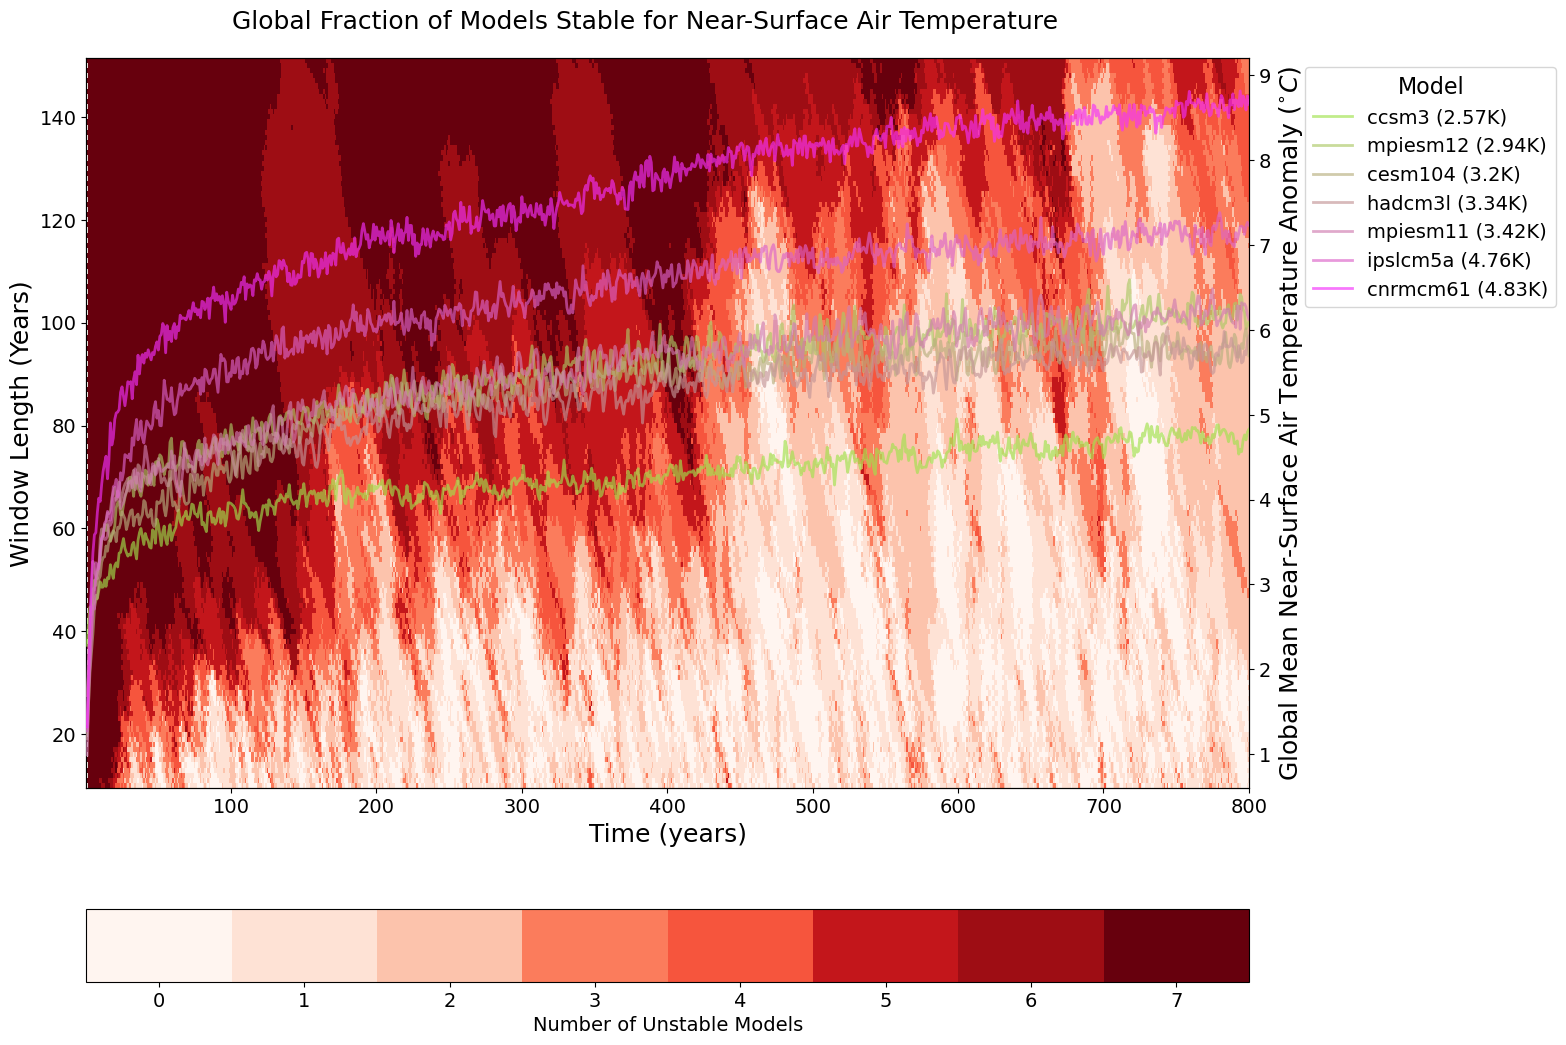

In [60]:
reload(sn_plot)
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax1, ax2, ax3,cbar = sn_plot.sn_multi_window_in_time(
    unstable_number_da, stable_number_da, abrupt4x_mean, 
    logginglevel='ERROR', 
    hieght = 15, width = 12,
    vmin=0, vmax=len(models)+1, step=1, cbartick_offset = 0.5,
    cmap=cmap,
    extend='neither', xupperlim = max_effective_length,
    cbar_label= 'Number of Unstable Models', 
    ax2_ylabel = f'Global Mean {longname} Anomaly ({units})',
    title = f'{hemisphere_title} Fraction of Models Stable for {longname} {mask_title}',
    cbar_ncols = 3, filter_max=True)

# ax1.set_ylabel('Window Length (Years)', fontsize=18)

save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{run_tag}_all_models_signal_to_noise_multiwindow.png')
print(save_name)
fig.savefig(save_name , dpi=200, bbox_inches='tight')